# Interpretation of SF vs Fantasy  models

This is fairly difficult analysis, and I decided that I didn't actually need the full subtlety of the analysis for the article. So I work through a lot of stuff below. But if you want to know what I actually ended up using in the article, consult the very end of the article, where I report "simple loss calculation."

**the hard stuff**

Degrees of divergence between closely-related models are not easy to measure, and SF and fantasy are, in general, closely related genres.

As explained [in another notebook (spacebetweengenres)](https://github.com/tedunderwood/measureperspective/blob/master/measuredivergence/spacebetweengenres.ipynb), the most sensitive way to measure the similarity of two models 

    1. A vs Z and 
    2. B vs Z

seems to be to compare the predictions of 1 on 2's data, and 2 on 1's data, with a Spearman correlation that has passed through Fisher's transformation (so it's no longer bounded at one). But this correlation needs to be normalized for the inherent stability of the underlying classes. In other words, you also need to compare multiple models of A on Z, and B on Z, and normalize the cross-comparison for the strength of the self-comparison. (You can't expect fantasy to predict SF better than it predicts itself, as it were!)

There are a couple of different ways to do that measurement. This is one version. Our goal is to ask *whether the closeness of the relationship between fantasy and science fiction has varied across time from the nineteenth century to the twenty-first*? The answer is yes. It's not a huge variation; these genres are always more closely related than either is, for instance, to detective fiction. But there is a significant change across time.

In [1]:
# Let's start with some standard imports.

import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import numpy as np
%matplotlib inline

In [2]:
# Load the data and take a look.

results = pd.read_csv('../results/reliable_comparisons.tsv', sep = '\t')
results.head()


,testype,name1,name2,ceiling,floor,meandate1,meandate2,acc1,acc2,alienacc1,alienacc2,spearman,spear1on2,spear2on1,loss,loss1on2,loss2on1,iteration
0,sfself,temp_sf11909_0,temp_sf21909_0,1909,1800,1877.048611,1886.173611,0.812500,0.895833,0.826389,0.847222,1.508482,1.465429,1.551534,0.017361,0.048611,-0.013889,0
1,fantasyself,temp_fant11909_0,temp_fant21909_0,1909,1800,1880.875000,1879.842857,0.742647,0.707143,0.742647,0.692857,0.716294,0.684094,0.748493,0.007143,0.014286,0.000000,0
2,cross,temp_sf11909_0,temp_fant21909_0,1909,1800,1877.048611,1879.842857,0.812500,0.707143,0.777778,0.650000,0.953938,0.804501,1.103375,0.045933,0.057143,0.034722,0
3,cross,temp_sf21909_0,temp_fant11909_0,1909,1800,1886.173611,1880.875000,0.895833,0.742647,0.784722,0.757353,0.954242,0.927479,0.981005,0.048203,-0.014706,0.111111,0
4,sfself,temp_sf11909_1,temp_sf21909_1,1909,1800,1880.819444,1881.833333,0.833333,0.895833,0.805556,0.833333,1.335162,1.298084,1.372241,0.045139,0.062500,0.027778,1


In [3]:
# Comparisons between F and SF can be grouped by period.
# Let's create normalization coefficients for each period

grouped = results.groupby('ceiling')
ceiling2meanself = dict()

for ceil, df in grouped:
    selfcomparisons = df[df.testype != 'cross']
    meanself = np.mean(selfcomparisons.spearman)
    ceiling2meanself[ceil] = meanself

def map2mean(a_ceiling):
    global ceiling2meanself
    return ceiling2meanself[a_ceiling]

newcol = results.ceiling.map(map2mean)
results = results.assign(normed = results.spearman/newcol)


Now we have a column (norm) that we can use to normalize the cross-comparisons. But by the way, while we're at it, the average strength of self-comparison is interesting. It correlates very strongly with the mean accuracy of models distinguishing SF and Fantasy from a random contrast set:

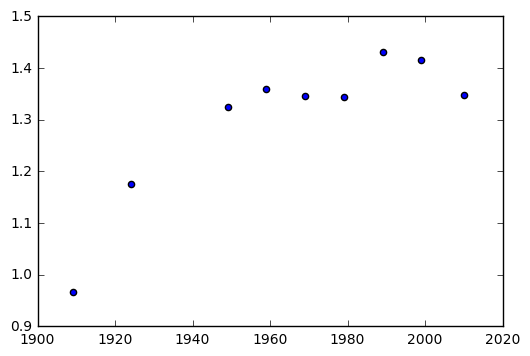

In [4]:
ceilings, means = zip(*[(k, v) for k, v in ceiling2meanself.items()])
plt.scatter(ceilings, means)
plt.show()

That pattern is something fantasy and science fiction have in common: they both, separately, become more distinct from mainstream literature.

### The core of the analysis

Now let's look at the degree of similarity *between* fantasy and science fiction. This is going to be a trend with a different curve.

We have 15 iterations for each period. We'll identify periods through the "ceiling" of the date range. Then we'll divide each period by iteration. For each iteration, we'll calculate a mean (normed) Spearman correlation between predictions of fantasy models on science fiction, and vice-versa. This will tell us, in essence,

**How good are models trained on one genre at predicting the other -- *relative* to the genres' ability to predict (different samples of) themselves? As we can see above, self-predictive ability does vary over time, so we'll report cross-predictive strength as a *percentage* of it.**

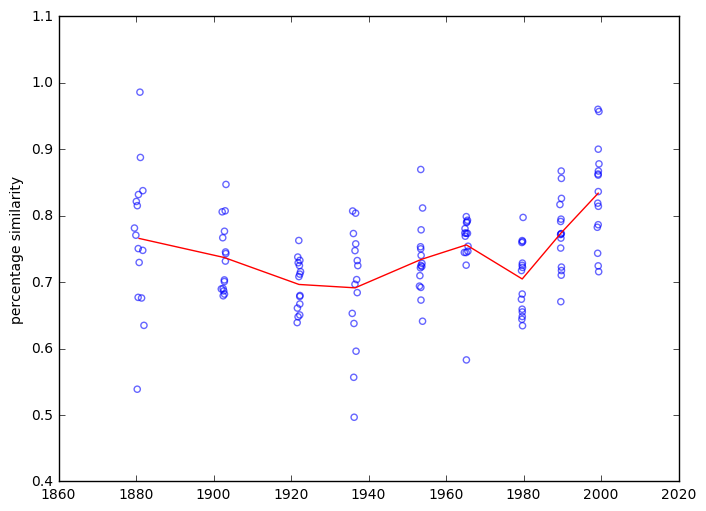

In [5]:
divergences = []
meandates = []
grouped_divergences = []
dates4groups = []

grouped = results.groupby('ceiling')
for ceil, df1 in grouped:
    nextlevel = df1.groupby('iteration')
    thisgroup = []
    thesedates = []
    for it, df2 in nextlevel:
        meanspear = np.mean(df2.normed[df2.testype == 'cross'])
        meandate1 = np.mean(df2.meandate1[df2.testype == 'cross'])
        meandate2 = np.mean(df2.meandate2[df2.testype == 'cross'])
        divergences.append(meanspear)
        thisgroup.append(meanspear)
        themeandate = (meandate1 + meandate2) / 2
        meandates.append(themeandate)
        thesedates.append(themeandate)
    dates4groups.append(np.mean(thesedates))
    grouped_divergences.append(thisgroup)

fig, ax = plt.subplots(figsize = (8, 6))
plt.scatter(meandates, divergences, facecolors = 'none', edgecolors = 'b', alpha = 0.6)
plt.ylabel('percentage similarity')
means4groups = [sum(x)/len(x) for x in grouped_divergences]
plt.plot(dates4groups, means4groups, color = 'r')
plt.show()


In [6]:
meandates = np.array(meandates)
divergences = 1 - np.array(divergences)
outframe = pd.DataFrame({'dates': meandates, 'divergence': divergences})
outframe.to_csv('groupedFSFdivergences.csv')

#### interpretation

It's not the crispest pattern in the world. And it depends on a lot of means relative to other means; the underlying data is a bit noisier even than it looks here. But if you trust the methodological argument of [spacebetweengenres](https://github.com/tedunderwood/measureperspective/blob/master/measuredivergence/spacebetweengenres.ipynb), this is pretty convincing evidence that fantasy and science fiction *diverge* at the start of the twentieth century, and then reconverge -- especially in the period 1990-2010.

If you prefer boxplots (I don't):

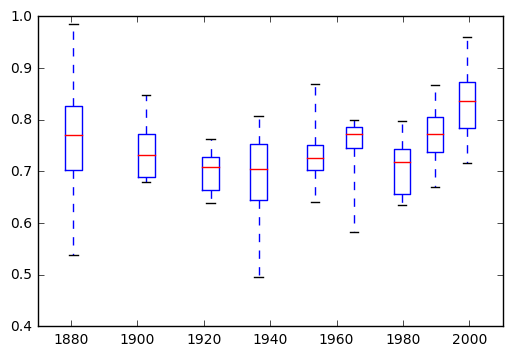

In [7]:
plt.boxplot(grouped_divergences, positions = dates4groups, widths = 5, whis = 'range')
plt.xlim(1870, 2010)
plt.xticks([1880, 1900, 1920, 1940, 1960, 1980, 2000],[1880, 1900, 1920, 1940, 1960, 1980, 2000])
plt.show()

#### testing the pattern

Suppose you said to yourself: it looks, visually, like fantasy and science fiction have become more similar from 1920 onward. But is that really true? Could I say that in a responsible way?

In [8]:
post1918dates, post1918divergences = zip(*[(date, diverge) for date, diverge in zip(meandates, divergences) if date > 1918])

In [9]:
pearsonr(post1918dates, post1918divergences)

(-0.49405243351249717, 8.5108855031896748e-08)

Yes, that's a strong linear relationship. It's by no means a close thing: definitely true.

## simple loss calculation

All that is nice, but it's going to be too much to explain in PMLA. So let's run a simpler calculation of lost accuracy.

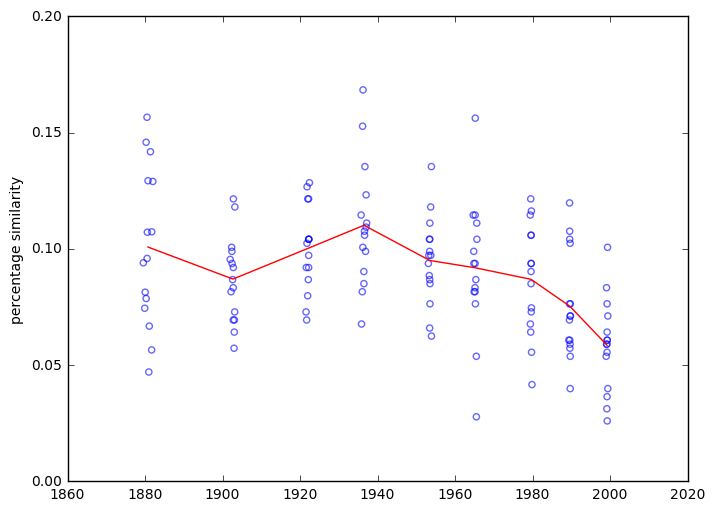

In [10]:
## Let's group results by period and calculate average loss for each period

meandates = []
meanlosses = []
dates4groups = []
grouped_divergences = []

grouped = results.groupby('ceiling')
for ceil, df1 in grouped:
    nextlevel = df1.groupby('iteration')
    thisgroup = []
    thesedates = []
    for it, df2 in nextlevel:
        meanloss = np.mean(df2.loss[df2.testype == 'cross'])
        meandate1 = np.mean(df2.meandate1[df2.testype == 'cross'])
        meandate2 = np.mean(df2.meandate2[df2.testype == 'cross'])
        meanlosses.append(meanloss)
        thisgroup.append(meanloss)
        themeandate = (meandate1 + meandate2) / 2
        meandates.append(themeandate)
        thesedates.append(themeandate)
    dates4groups.append(np.mean(thesedates))
    grouped_divergences.append(thisgroup)

fig, ax = plt.subplots(figsize = (8, 6))
plt.scatter(meandates, meanlosses, facecolors = 'none', edgecolors = 'b', alpha = 0.6)
plt.ylabel('percentage similarity')
means4groups = [sum(x)/len(x) for x in grouped_divergences]
plt.plot(dates4groups, means4groups, color = 'r')
plt.show()

In [11]:
means4groups

[0.10081642605666664,
 0.08703703704,
 0.10023148148333334,
 0.11018518518666666,
 0.09502314814333333,
 0.09189814815333334,
 0.08692129629666664,
 0.07534722221333333,
 0.058564814810000004]